In [1]:
# Data handling
import pandas as pd 
import numpy as np

# Clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize

# Dimensionality reduction
from sklearn.decomposition import PCA


# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.style as style
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
def prepare_pca(n_components, data, kmeans_labels):
    """ prepare pca with n dimension
    """
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    """ plot 3d scatter
    """
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',color=name)
    fig.update_traces(marker=dict(size=3))
    fig.show()
    
    
def load_preprocess_data():
    """ Load and preprocess data
    """
    # load dataset
    df = pd.read_csv('data_credit_card_customer_seg.csv')
    
    # handle missing values by replace it by means
    df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
    df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(), inplace=True)
    
    # drop unnecessary column
    df.drop('CUST_ID', axis=1, inplace=True)
    
    return  df

df = load_preprocess_data()
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000        864.206542          0.000000      12  
4   678.334763        244.791237          0.000000      12

## Data Standardization(Z-score Normalization)

In [4]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(df) 

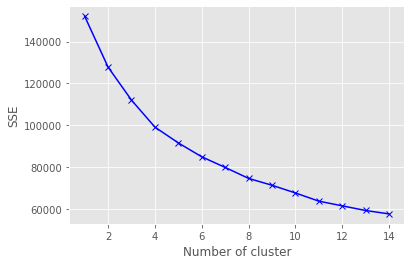

In [5]:
style.use('ggplot')

# Choosing the K value using elbow method 
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(scaled_df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

It's hard to find the elbow point of the curve, so we use silhouette score.

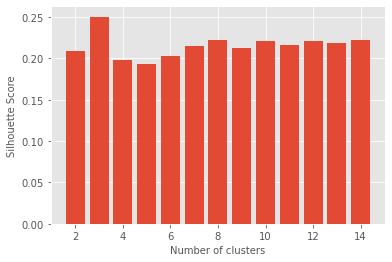

In [6]:
# silhouette score
silhouette_scores = []

for n_cluster in range(2, 15):
    silhouette_scores.append( 
        silhouette_score(scaled_df, KMeans(n_clusters = n_cluster).fit_predict(scaled_df))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Highest silhouette score is k = 3.

# Kmeans clustering

Let's visualize k=3,4

# k=3

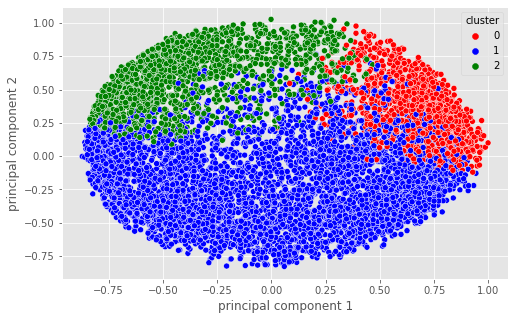

In [12]:
# Kmeans algorithm
kmean= KMeans(n_clusters=3,init='k-means++')
kmean.fit(scaled_df)
labels=kmean.labels_

# feature scaling for visualization
scaler = StandardScaler() 
scaled = scaler.fit_transform(df) 

# Normalizing the Data 
normalized_df = normalize(scaled) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot( data=finalDf,x="principal component 1", y="principal component 2", hue="cluster",palette=['red','blue','green'])
plt.show()

In [37]:
#3D plot
pca_df = prepare_pca(3, normalized_df, labels)
plot_3d(pca_df)

In [8]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'].value_counts()

2    6119
1    1596
0    1235
Name: cluster, dtype: int64

In [9]:
clusters.groupby('cluster').mean()

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
cluster                                                                  
0        2220.003291           0.981477  4268.520980       2717.828543   
1        3989.326804           0.957980   384.528277        248.718133   
2         799.702576           0.835188   505.532394        253.120131   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
cluster                                                              
0                   1551.178267    458.421147             0.949093   
1                    135.887632   3869.856855             0.232290   
2                    252.733061    329.866776             0.465072   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
cluster                                                                 
0                          0.668166                          0.744584   
1                          0.110942                          0.144242   
2                          0.132333                          0.345145   

         CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
cluster                                                            
0                      0.063014          1.528745      56.472065   
1                      0.447176         12.390351       5.612155   
2                      0.068316          1.211636       8.653865   

         CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
cluster                                                                  
0         7733.967611  4151.276172       1224.538588          0.298632   
1         6682.960242  3018.907202       1795.687341          0.033774   
2         3269.793763   909.729614        548.525315          0.155750   

            TENURE  
cluster             
0        11.923077  
1        11.350877  
2        11.478836

Text(0.5, 0, 'SEGMENTS')

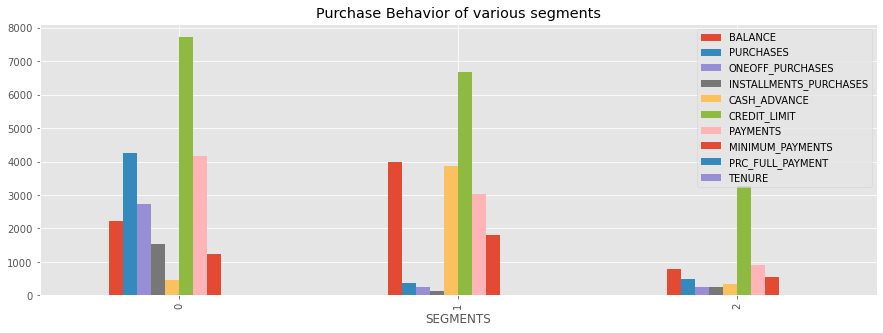

In [10]:
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')

## k=4

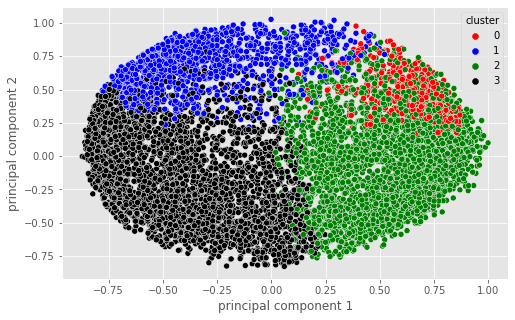

In [13]:
# Kmeans algorithm
kmean= KMeans(n_clusters=4,init='k-means++',n_init=10)
kmean.fit(scaled_df)
labels=kmean.labels_


# feature scaling for visualization
scaler = StandardScaler() 
scaled = scaler.fit_transform(df) 

# Normalizing the Data 
normalized_df = normalize(scaled) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot(x="principal component 1", y="principal component 2", hue="cluster", data=finalDf,palette=['red','blue','green','black'])
plt.show()

In [14]:
pca_df = prepare_pca(3, normalized_df, labels)
plot_3d(pca_df)

In [15]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'].value_counts()

3    3976
2    3367
1    1198
0     409
Name: cluster, dtype: int64

In [16]:
clusters.groupby('cluster').mean()

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
cluster                                                                  
0        3551.153761           0.986879  7681.620098       5095.878826   
1        4602.462714           0.968415   501.896219        320.373681   
2         894.907458           0.934734  1236.178934        593.974874   
3        1011.751528           0.789871   269.973466        209.853863   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
cluster                                                              
0                   2587.208264    653.638891             0.946418   
1                    181.607404   4520.724309             0.287731   
2                    642.478274    210.570626             0.885165   
3                     60.386625    595.759339             0.170146   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
cluster                                                                 
0                          0.739031                          0.788060   
1                          0.138934                          0.185516   
2                          0.297070                          0.711842   
3                          0.086281                          0.080578   

         CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
cluster                                                            
0                      0.071290          2.085575      89.359413   
1                      0.484526         14.284641       7.661102   
2                      0.042573          0.790021      22.091773   
3                      0.114833          2.125503       2.903421   

         CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
cluster                                                                  
0         9696.943765  7288.739497       1976.815179          0.286707   
1         7546.957050  3481.145990       2008.251157          0.034859   
2         4213.207678  1332.194205        650.167072          0.269258   
3         3277.703165   974.505090        586.301239          0.078001   

            TENURE  
cluster             
0        11.951100  
1        11.387312  
2        11.594595  
3        11.446429

Text(0.5, 0, 'SEGMENTS')

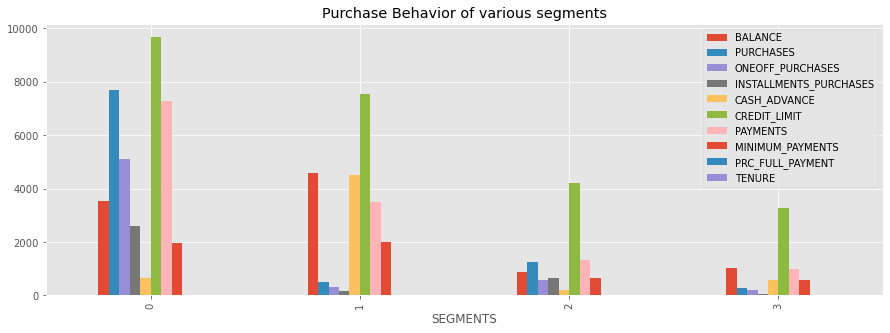

In [17]:
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')